# Compare CI to traditional ML methods

In [ ]:
# Load packages
import pandas as pd
import numpy as np
import pickle
import networkx as nx

from scipy.stats import linregress
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

from MScausality.simulation.example_graphs import signaling_network
from MScausality.simulation.simulation import simulate_data
from MScausality.data_analysis.dataProcess import dataProcess

import warnings
warnings.filterwarnings('ignore')

# Generate some data

In [21]:
sn = signaling_network()
simulated_data = simulate_data(sn['Networkx'], 
                                coefficients=sn['Coefficients'], 
                                mnar_missing_param=[-4, .3],
                                add_feature_var=True, n=100, seed=2)
input_data = dataProcess(simulated_data["Feature_data"], normalization=False, 
            summarization_method="TMP", MBimpute=True, sim_data=True)

simulating data...
adding feature level data...
masking data...


In [22]:
imputer = KNNImputer(n_neighbors=3, keep_empty_features=True)
input_data = pd.DataFrame(imputer.fit_transform(input_data), 
                                columns=input_data.columns)

# ML methods

In [23]:
# Prep data
X = input_data.loc[:, ["SOS", "PI3K", "Ras", "Raf", "Akt", 
                       "Mek", "Ins", "Nfkb", "Jnk"]]
y = input_data["Erk"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1)

## Linear Regression

In [24]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [25]:
dict(
    zip(["SOS", "PI3K", "Ras", "Raf", "Akt", 
         "Mek", "Ins", "Nfkb", "Jnk"], 
         lm.coef_)
)

{'SOS': 0.005961285537859617,
 'PI3K': 0.011323224155538325,
 'Ras': -0.03937135518480204,
 'Raf': 0.0038615021001674743,
 'Akt': 0.0866563713307549,
 'Mek': 0.19516158253098273,
 'Ins': -0.05577401643706542,
 'Nfkb': 0.24016503910019202,
 'Jnk': 0.3024813142749972}

## Random Forest

In [26]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
np.sqrt(np.mean((y_test - rf.predict(X_test))**2))

0.5105390966536492

In [27]:
dict(
    zip(["SOS", "PI3K", "Ras", "Raf", "Akt", 
         "Mek", "Ins", "Nfkb", "Jnk"], 
         rf.feature_importances_)
)

{'SOS': 0.0019809105670457483,
 'PI3K': 0.0023102887282554483,
 'Ras': 0.0039056901157221717,
 'Raf': 0.005646991963493164,
 'Akt': 0.002149071187651001,
 'Mek': 0.013391286995966563,
 'Ins': 0.0055246835238458225,
 'Nfkb': 0.2207182516509782,
 'Jnk': 0.7443728252670417}

## XGBoost

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

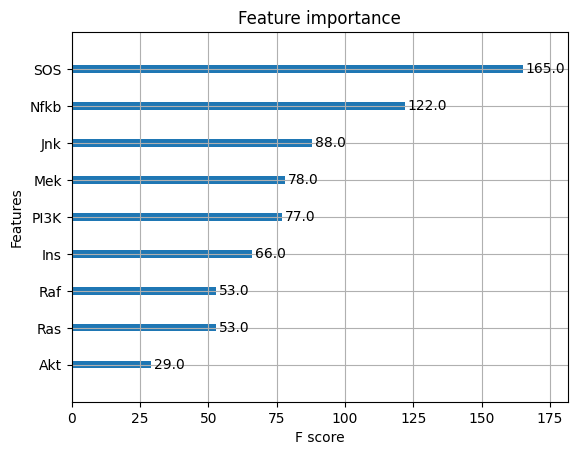

In [28]:
dtrain_reg = xgb.DMatrix(X_train, y_train)
params = {"objective": "reg:squarederror"}

n = 100
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

xgb.plot_importance(model)